### **1. Data Preparation**
Load the data stored in Google Drive

In [1]:
!mkdir '/content/data'
!unzip "/content/drive/My Drive/COMP9517 20T2 Group Project Image Sequences.zip" -d '/content/data'

Archive:  /content/drive/My Drive/COMP9517 20T2 Group Project Image Sequences.zip
   creating: /content/data/DIC-C2DH-HeLa/
   creating: /content/data/DIC-C2DH-HeLa/Sequence 1/
   creating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t002mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t005mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t021mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t031mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t033mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t034mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t039mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t054mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1 Masks/t067mask.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Sequence 1/t000.tif  
  inflating: /content/data/DIC-C2DH-HeLa/Seq

Quick-Load Testing

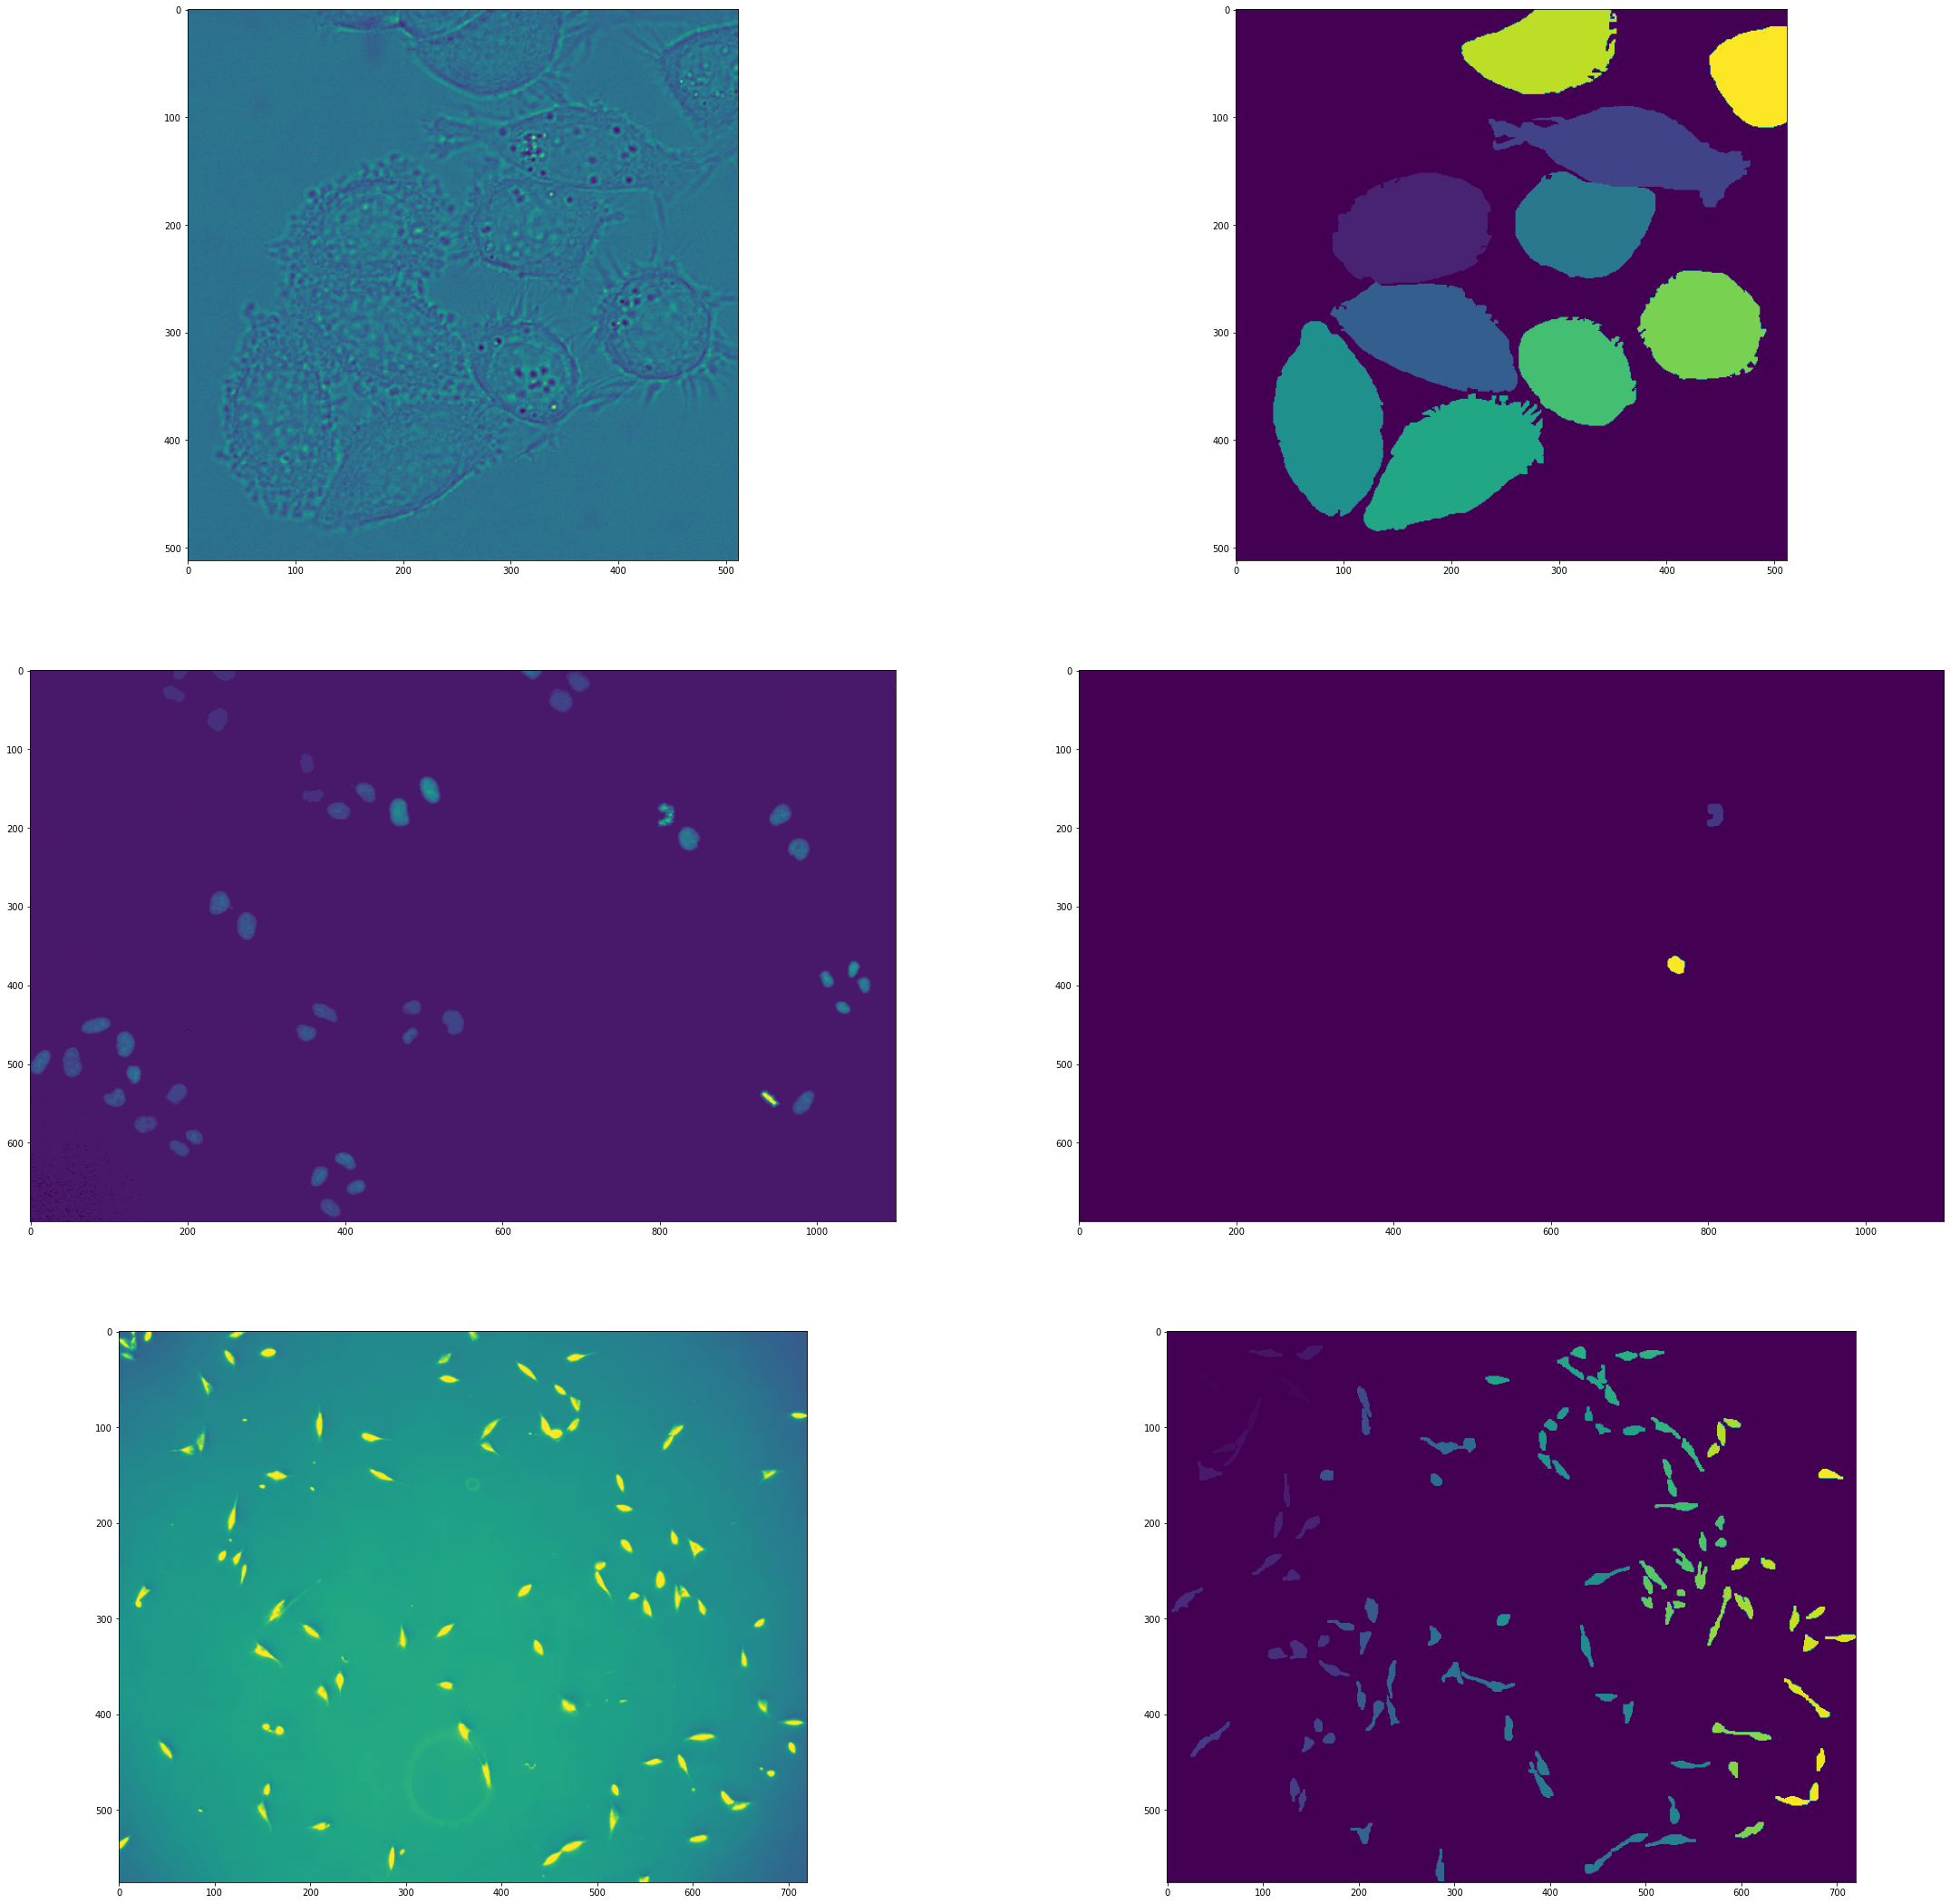

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from os.path import join

dic_path = '/content/data/DIC-C2DH-HeLa/'
fluo_path = '/content/data/Fluo-N2DL-HeLa/'
phc_path = '/content/data/PhC-C2DL-PSC/'

# test img display
f = plt.figure(figsize=(38, 38))
# dic
dic_test = cv2.imread(join(dic_path, 'Sequence 1/t002.tif'),0)
dic_testmask = cv2.imread(join(dic_path, 'Sequence 1 Masks/t002mask.tif'), -1)
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax1.imshow(dic_test)
ax2.imshow(dic_testmask)
# fluo
fluo_test = cv2.imread(join(fluo_path, 'Sequence 1/t012.tif'),0)
fluo_testmask = cv2.imread(join(fluo_path, 'Sequence 1 Masks/t012mask.tif'), -1)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax3.imshow(fluo_test)
ax4.imshow(fluo_testmask)
# phc
phc_test = cv2.imread(join(phc_path, 'Sequence 1/t000.tif'),0)
phc_testmask = cv2.imread(join(phc_path, 'Sequence 1 Masks/t098mask.tif'), -1)
ax5 = f.add_subplot(3,2,5)
ax6 = f.add_subplot(3,2,6)
ax5.imshow(phc_test)
ax6.imshow(phc_testmask)

### **2. Data Preprocessing**
Aiming to generate high-accuracy binarial cell labelling to facilitate the process of finding contours later.

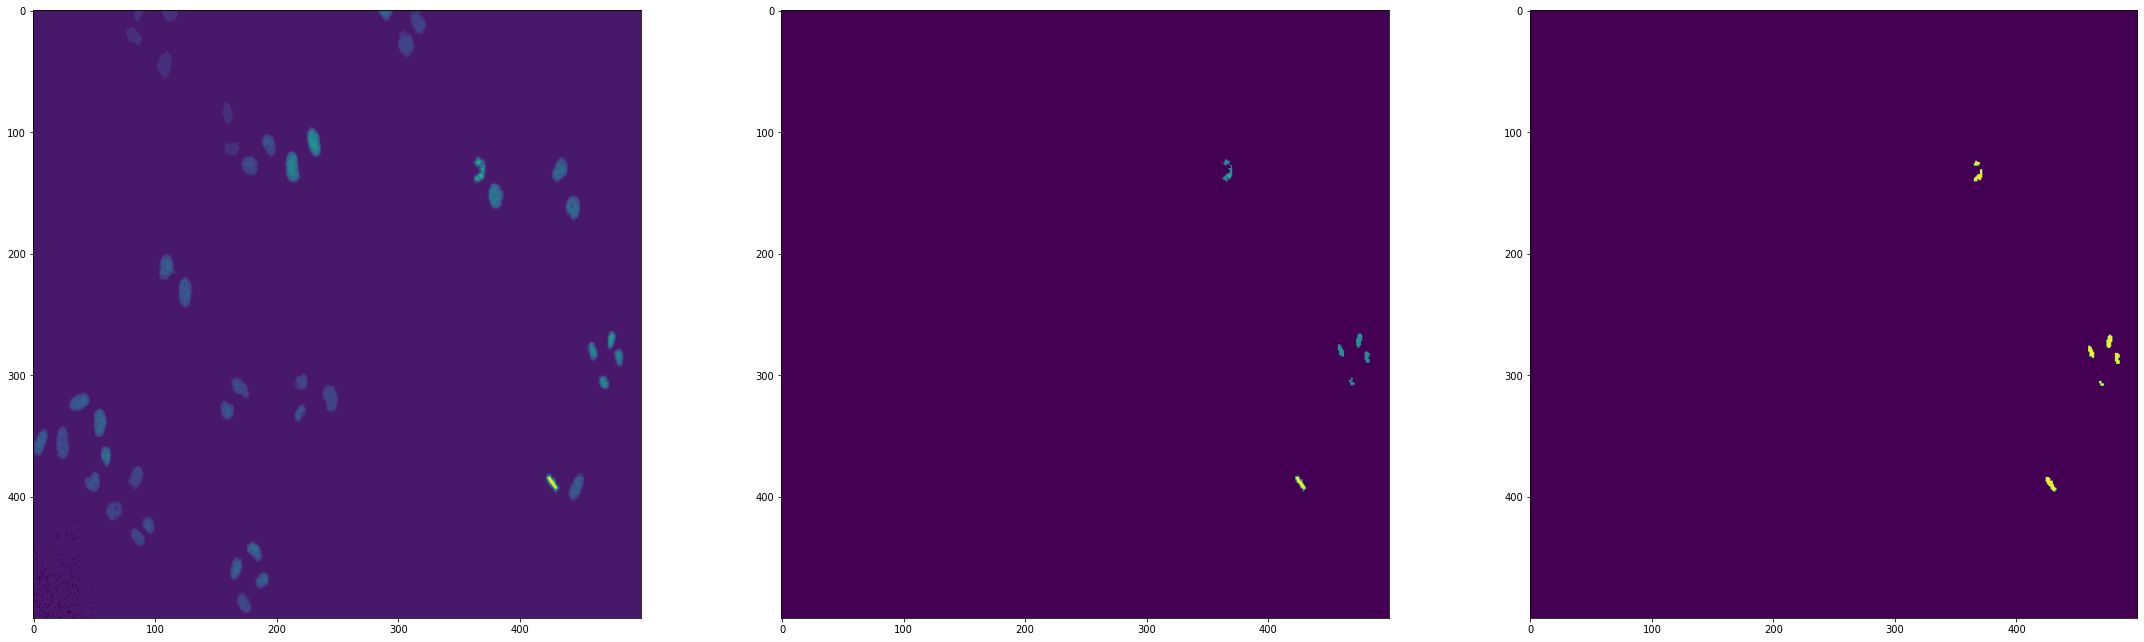

In [8]:
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

def full_min_max_filter(img, N):
    o = None
    b = cv2.dilate(cv2.erode(img, np.ones((N,N),np.uint8)), np.ones((N,N),np.uint8))
    o = img - b
    
    # clipping out-of-range value
    o[o < 0] = 0
    o[o > 255] = 255
    
    return o

def thres_preprocessing(img, alpha, beta, minmax_N, morph_open, f = None, i = None):
    resized_img = cv2.resize(img, (500, 500))
    resized_copy = resized_img

    distance = ndi.distance_transform_edt(resized_img)
    local_maxi = peak_local_max(distance, indices=False, labels=resized_img)

    resized_img = np.clip(alpha*resized_img + beta, 0, 255)

    resized_img = full_min_max_filter(resized_img, minmax_N)
    resized_img = resized_img.astype(np.uint8)
    st = cv2.adaptiveThreshold(resized_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,10)
    
    # Otsu's thresholding
    ret,th = cv2.threshold(resized_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) 
    th = cv2.morphologyEx(th, cv2.MORPH_OPEN, np.ones((morph_open,morph_open),np.uint8)) 
    
    """
    Debug-use img showing, need to include a figure of f
    """
    if f != None and i != None:  
        ax = f.add_subplot(3,3,i)
        ax.imshow(resized_copy)
        ax0 = f.add_subplot(3,3,i+1)
        ax0.imshow(resized_img)
        ax1 = f.add_subplot(3,3,i+2)
        ax1.imshow(th)

    return resized_img, th # return resized img, threshold type1, threshold type2

# Test uses
f2 = plt.figure(figsize=(38, 38))
# dic_resized, dic_th, dic_th2 = thres_preprocessing(dic_test, f2, 1)
fluo_resized, fluo_th = thres_preprocessing(fluo_test, 0.2, 10, 7, 2, f2, 4)
# phc_resized, phc_th = thres_preprocessing(phc_test, 1.3, 40, 7, 2, f=f2, i=7)

### **Section 3. Finding Contours and Bounding Boxes**
Provide contour coordinates for later tracking missions. Also use the coordinates to provide bounding box details.

#### **Bounding Box Tools**
Give a set of functions that could be handy for quickly generating bounding boxes uniformly.

In [ ]:
def add_boundingbox(path, img, ls): # overwrite the file at the path with the bounding-boxed img
    label_img = label(ls)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

    for region in regionprops(label_img):
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                    fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(path)
        
def add_boundingbox_for_all(src, dest, iteration = 250, # operational arguments for level-set parameter tuning
                                     initial_ls_type='default', 
                                     level_size=4):
    if not path.exists(dest):
        destination = shutil.copytree(src, dest, copy_function = shutil.copy)

    # count how many images to process
    count = 0
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            count += 1
    
    # do the boundings in the dest repo
    progress = ProgressBar()
    i = 0
    progress.update_progress(0)
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            # load the img
            img = cv2.imread(path.join(dirpath, file),0)
            # do img preprocessing
            resized_img, thres, thres2 = thres_preprocessing(img)
            # get the segmentation
            # The first output is the final segmentation result
            # The second output contains all history segmentation results during 
            # the level-set converging procedure
            ls, _ = level_set_segmentation(thres, iteration = iteration,
                                                level_set=initial_ls_type, 
                                                level_size=level_size)
            # get the bounding-boxes
            add_boundingbox(path.join(dirpath, file), resized_img, ls)

            # progress bar
            i += 1
            progress.update_progress(i/count)

#### **Method-1: Use Level-Set Method.**
Provide good segmentation for simple cell images, but could not deal with heavily-clustered cells very well.

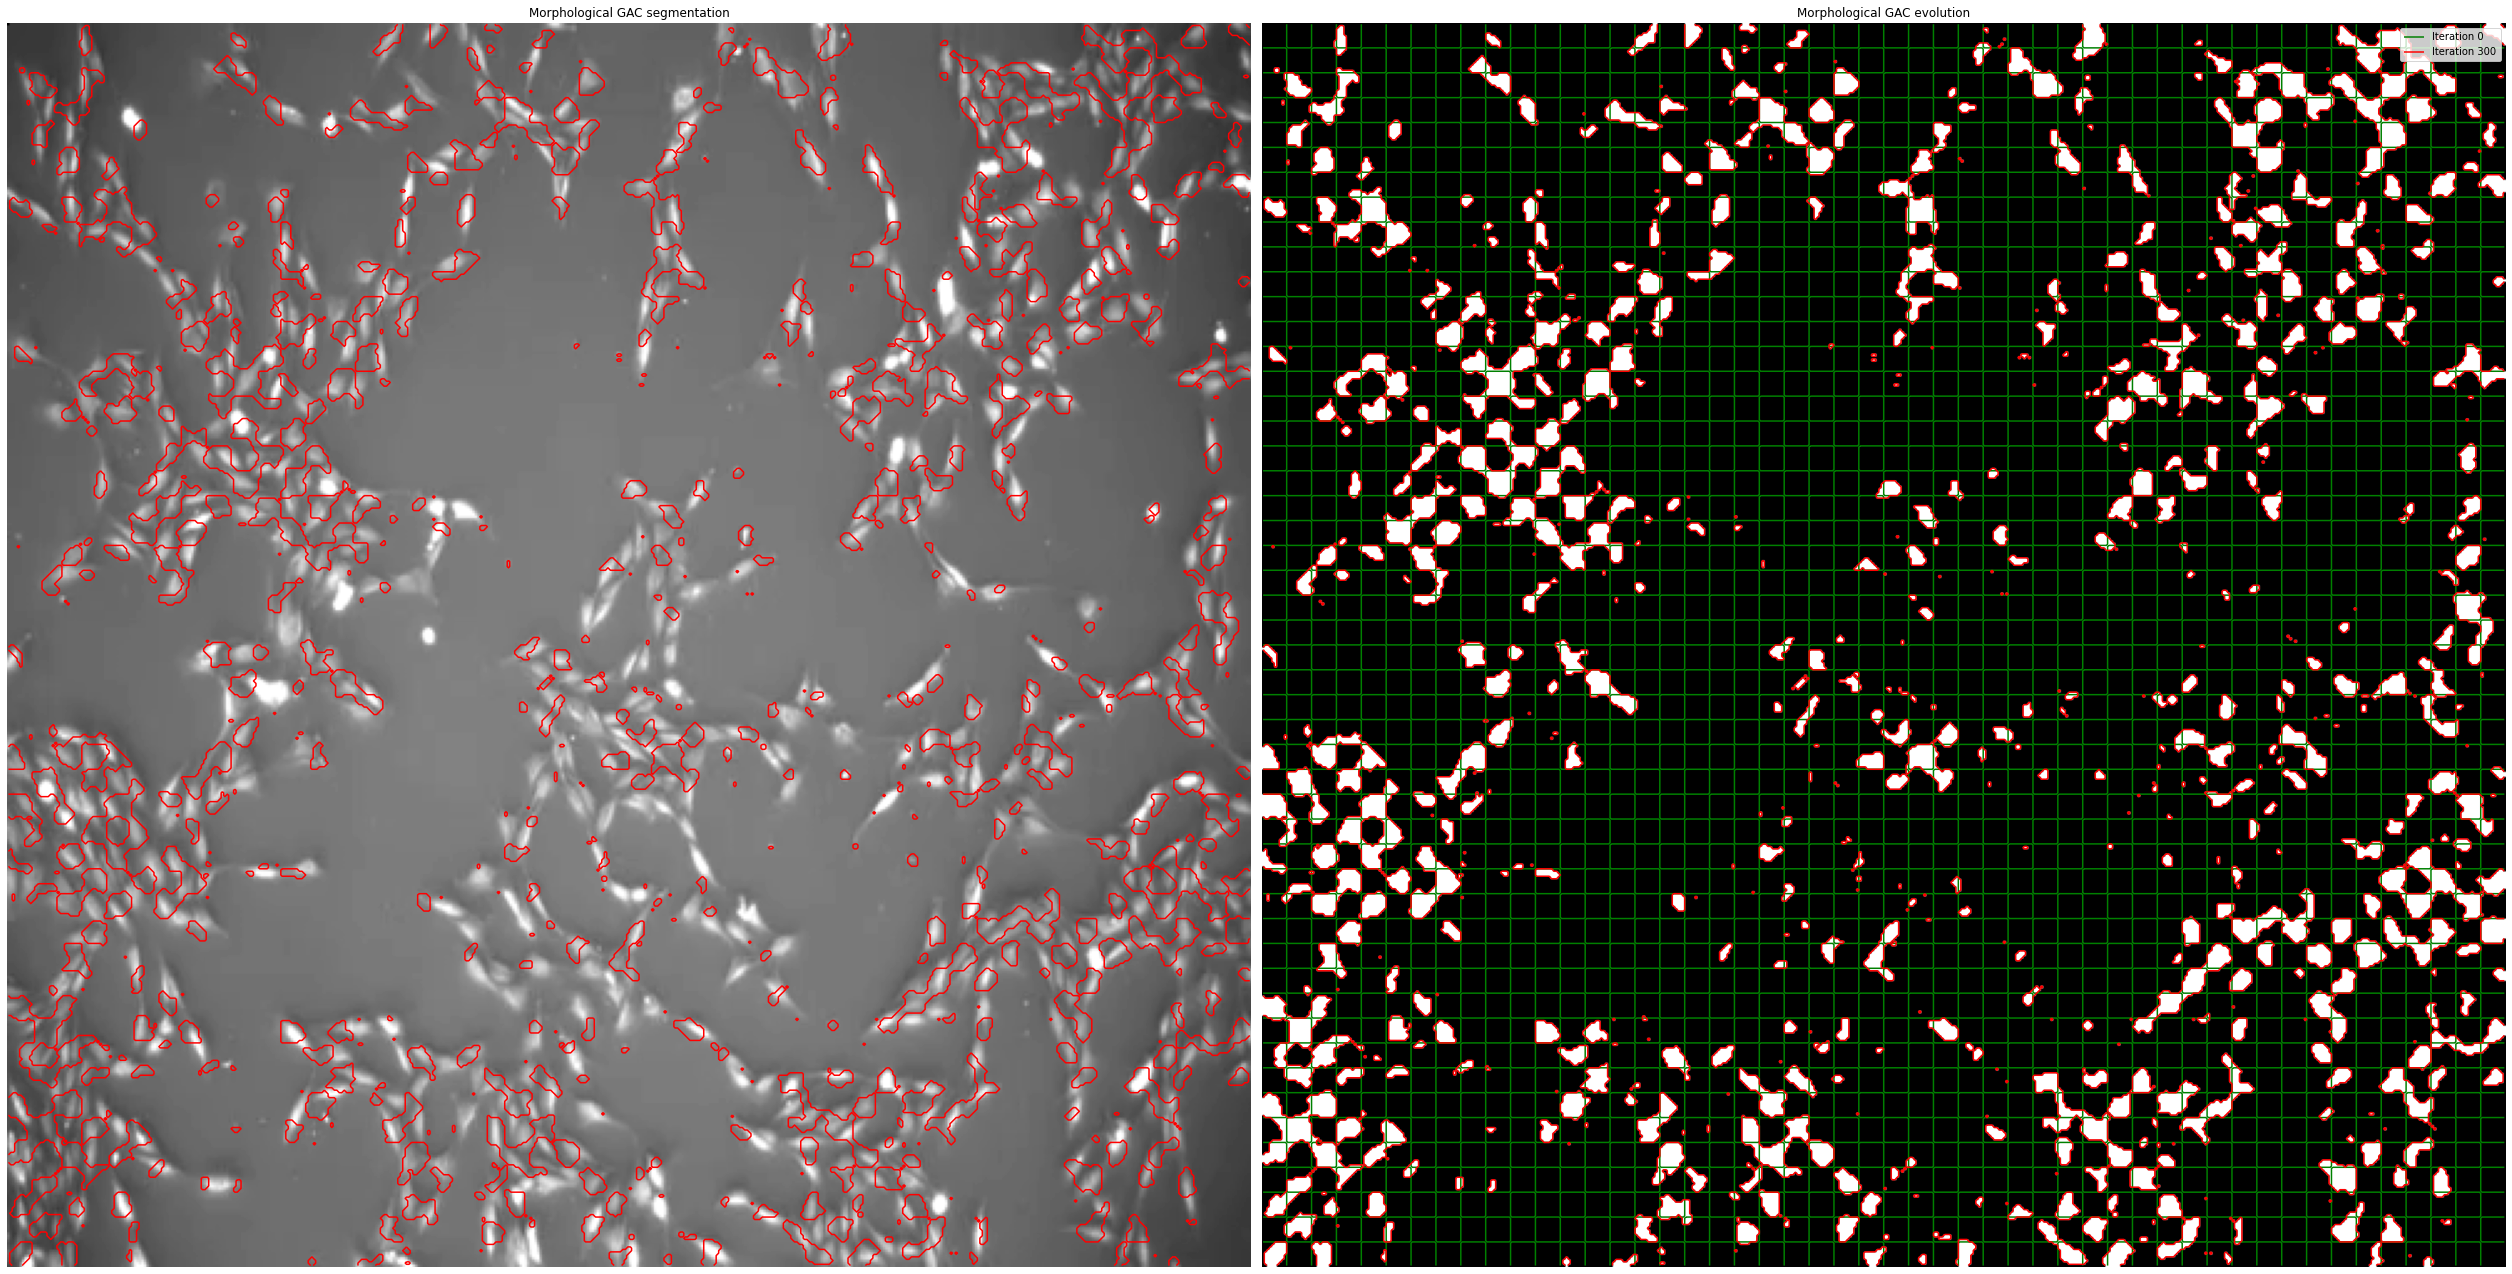

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,circle_level_set,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

def initial_circle_ls(shape, level_size):
    circles_ls = np.zeros(shape)
    x, y = shape
    for i in range(level_size):
        for j in range(level_size):
            cls = circle_level_set(shape, 
                                   (int(x/(level_size*2) + i* (x/level_size)), 
                                    int(y/(level_size*2) + j* (y/level_size))), 
                                   int(x/(level_size*2)))
            circles_ls += cls
    return circles_ls
    
def level_set_segmentation(img, iteration = 300,
                                level_set='default', 
                                level_size=4):
    # get gradients
    gimg = inverse_gaussian_gradient(img, alpha=1.0, sigma=1.0)

    init_ls = None
    # decide level set type
    if level_set == 'default':
        init_ls = np.zeros(img.shape, dtype=np.int8)
        init_ls[5:-5, 5:-5] = 1
    elif level_set == 'checkerboard':
        init_ls = checkerboard_level_set(img.shape, level_size)
        reverse_ls = checkerboard_level_set
    elif level_set == 'circles':
        init_ls = initial_circle_ls(img.shape, level_size)
    
    # List with intermediate results for plotting the evolution
    evolution = []
    callback = store_evolution_in(evolution)
    ls = morphological_geodesic_active_contour(gimg, iteration, init_ls,
                                               smoothing=1, balloon=-1,
                                               threshold=0.8,
                                               iter_callback=callback)
    
    return ls, evolution

# test 
img2 = cv2.resize(phc_test, (500, 500))
img = cv2.resize(phc_th, (500, 500))
ls, evolution = level_set_segmentation(img, 250, 'checkerboard', 10)

fig, axes = plt.subplots(1, 2, figsize=(35, 35))
ax = axes.flatten()
ax[0].imshow(img2, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].imshow(ls, cmap="gray")
ax[1].set_axis_off()
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 300")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

#### **Method-2: Use Marching Squares Algorithm**
Generally could handle with most types of the cell images.

In [ ]:
from skimage.measure import label, regionprops,find_contours
import matplotlib.patches as mpatches
import os.path as path
import shutil
import os
from progress_bar import ProgressBar
from numpy import save

def label_contours(src, dest, alpha, beta, minmax_N, morph_open, noise_level=3):
    if not path.exists(dest):
        destination = shutil.copytree(src, dest, copy_function = shutil.copy)

    # count how many images to process
    count = 0
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            count += 1
    
    # do the boundings in the dest repo
    progress = ProgressBar()
    i = 0
    progress.update_progress(0)
    for (dirpath, dirnames, filenames) in os.walk(dest):
        for file in filenames:
            file_type = (dirpath.split('/')[-1]).split(' ')[-1]
            if file_type == 'Masks':  # skip labels
                continue
            # load the img
            img = cv2.imread(path.join(dirpath, file),0)
            # do img preprocessing
            resized_img, thres = thres_preprocessing(img, alpha, beta, minmax_N, morph_open)
            # get the contours
            contours = find_contours(thres, 0.5)
            # stor coordinate results
            progress.update_progress((i+1)/count)
            store_contours(contours, path.join(dirpath, file), resized_img, noise_level)

            # progress bar
            i += 1

def store_contours(contours, dest, img, noise_level):
    results = []
    i = 0
    for contour in contours:
        x1 = np.min(contour[:,0]).astype(np.int)
        x2 = np.max(contour[:,0]).astype(np.int)
        y1 = np.min(contour[:,1]).astype(np.int)
        y2 = np.max(contour[:,1]).astype(np.int)
        if x2-x1 < noise_level or y2-y1 < noise_level: 
            continue
        label = i
        cropped_img = img[x1:x2,y1:y2]
        results.append((label, cropped_img, x1, x2, y1, y2))
    results = np.array(results)
    # save
    store_path = dest.split('.')[0]+'.npy'
    save(store_path, results)

label_contours(phc_path, '/content/phc/',1.3, 40, 7, 2)

Progress: [####################] 100.0%


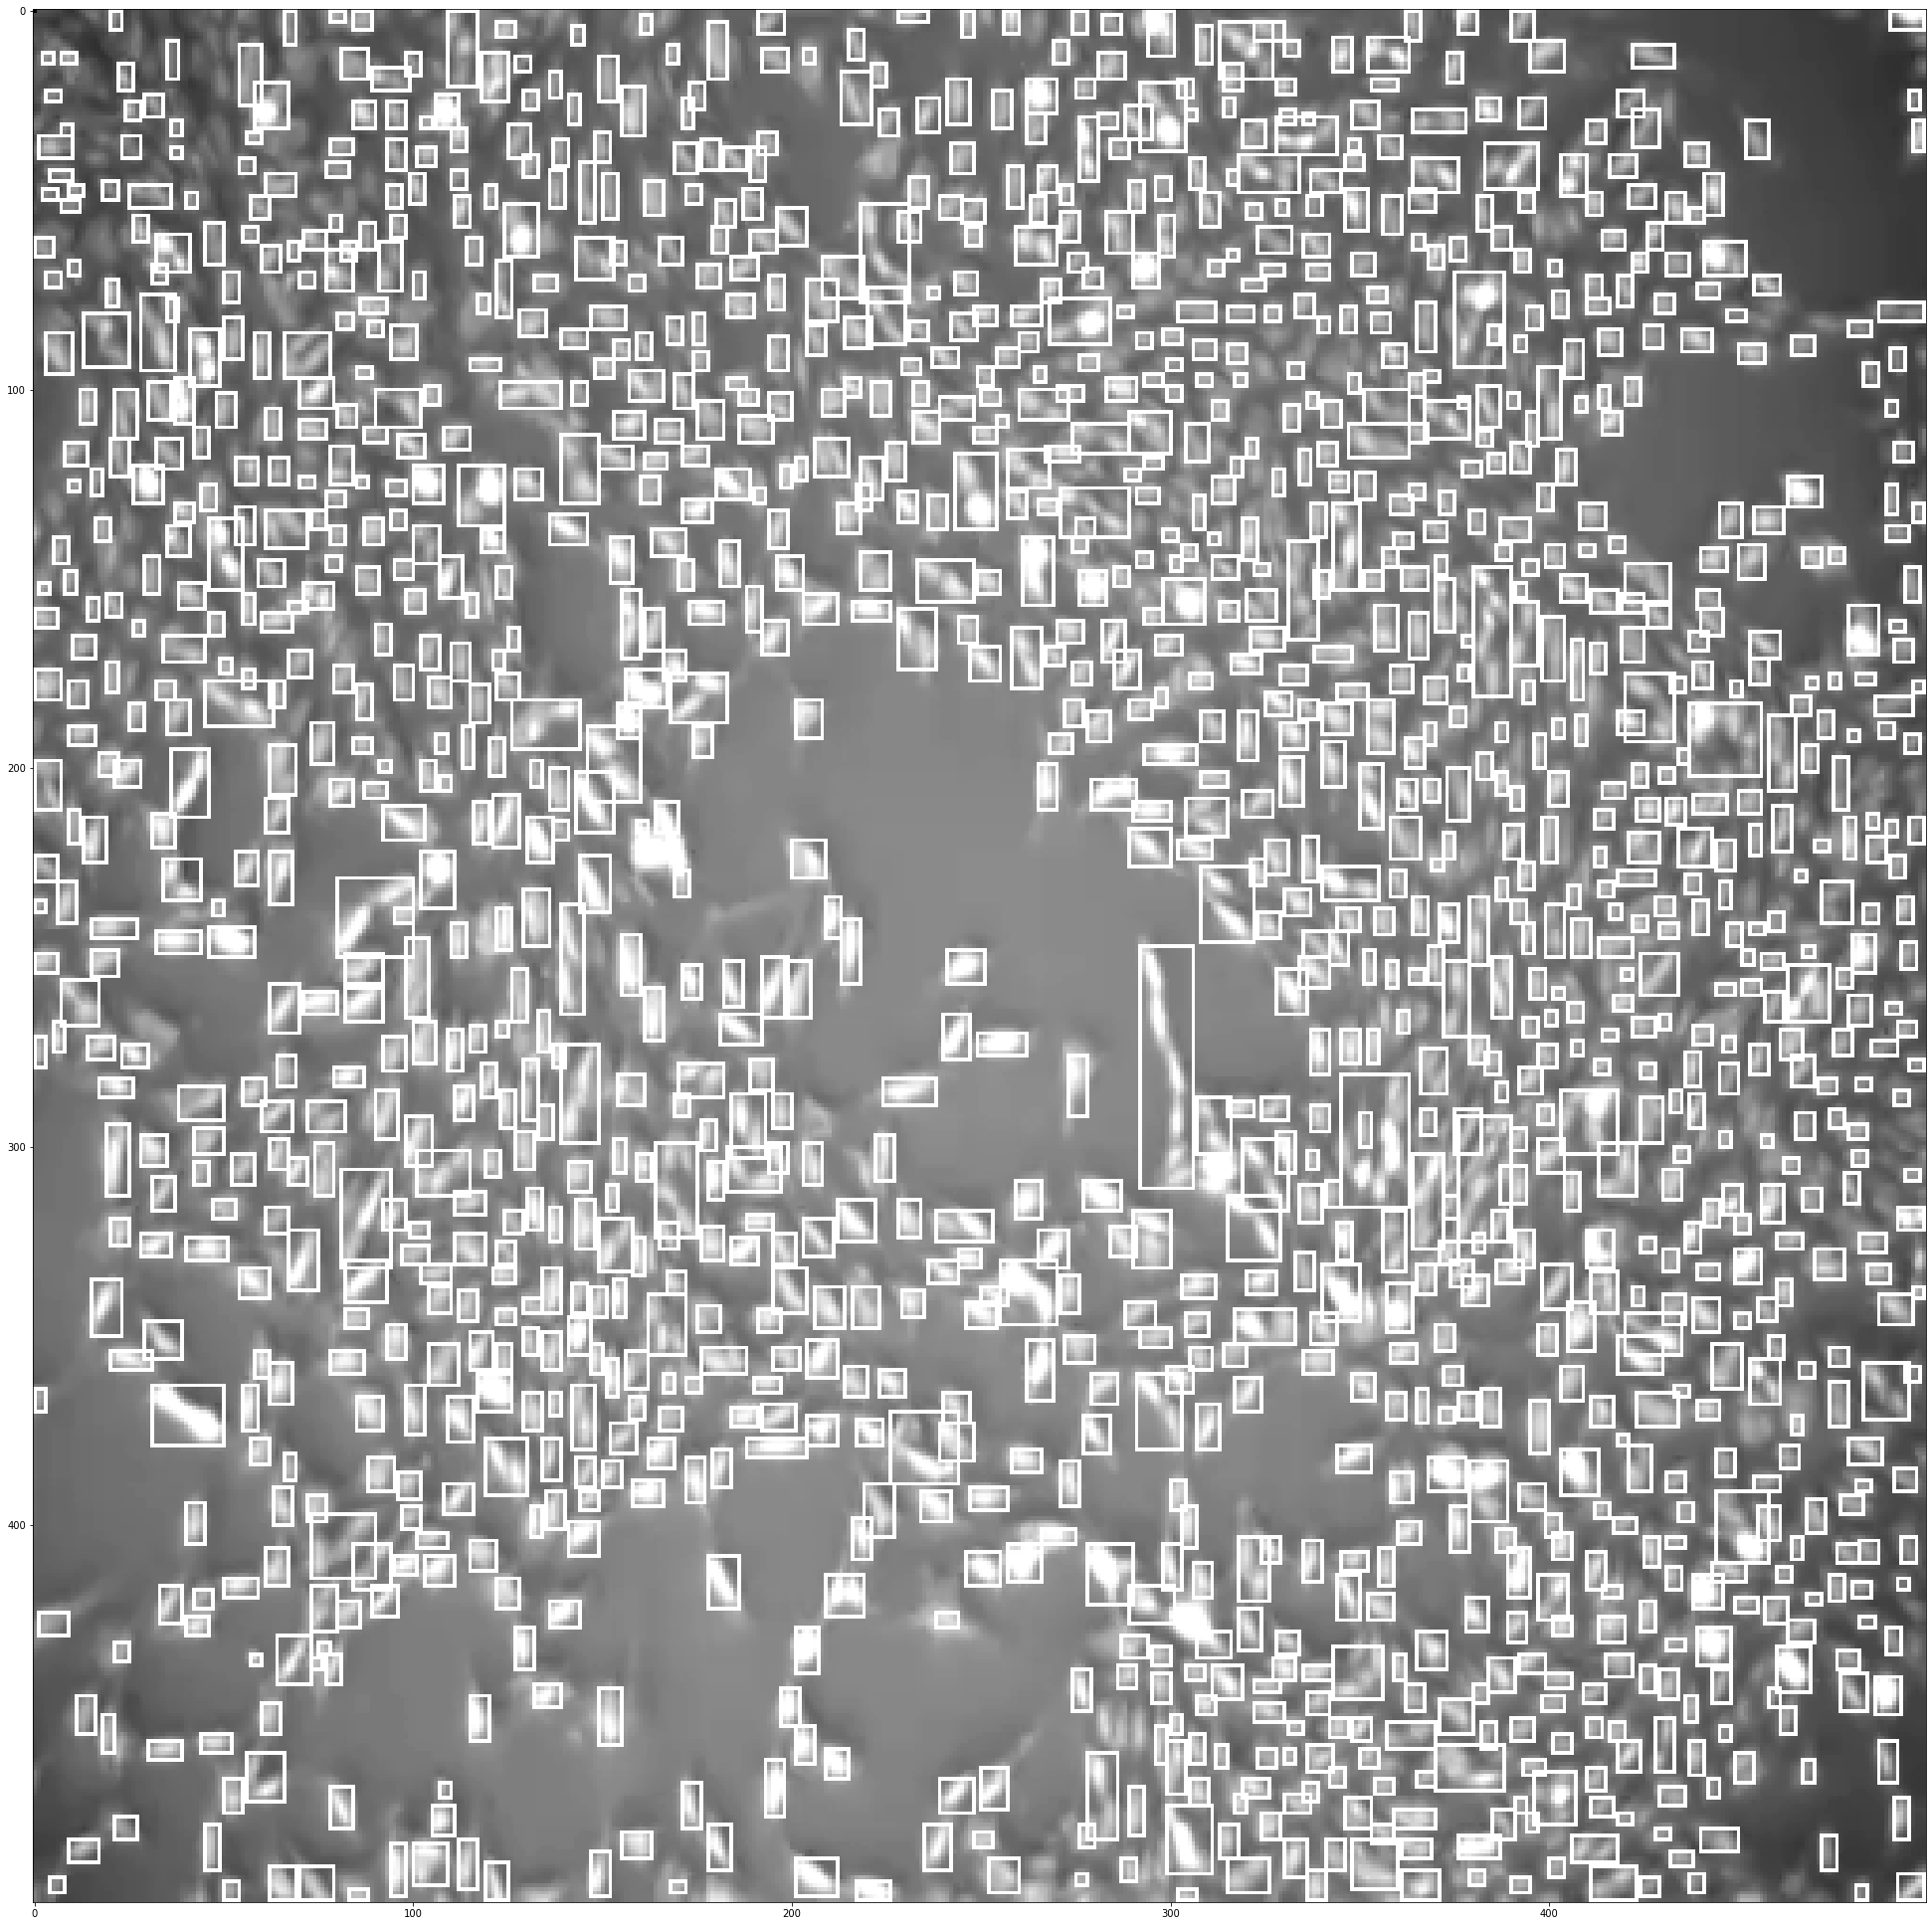

In [ ]:
# A quick test on whether the saved numpy could be re-loaded and used

from numpy import load

test = load('/content/phc/Sequence 1/t425.npy',allow_pickle=True)
phc_test = cv2.imread('/content/phc/Sequence 1/t425.tif',0)

with_boxes  = np.copy(cv2.resize(phc_test, (500, 500)))
plt.figure(figsize=(35, 35))

for each in test:
    a, b, c, d, e, f = each
    #[Xmin, Xmax, Ymin, Ymax]
    r1 = [c,d,d,c, c]
    c1 = [e,e,f,f, e]
    rr, cc = polygon_perimeter(r1, c1, with_boxes.shape)
    with_boxes[rr, cc] = 255 #set color white
plt.imshow(with_boxes, interpolation='nearest', cmap=plt.cm.gray)
plt.show()